# (Optional) Colab Setup
If you aren't using Colab, you can delete the following code cell. This is just to help students with mounting to Google Drive to access the other .py files and downloading the data, which is a little trickier on Colab than on your local machine using Jupyter.

In [1]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/ICV_final" $datadir # TODO: Fill your A3 path
os.chdir(datadir)
!pwd

/content/drive/My Drive/ICV_final


#Data Setup

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random

ROTATION_ANGLE = [0,90,180,270]

def rotate_img(img, rot):
    rot = ROTATION_ANGLE[rot]
    if rot == 0: # 0 degrees rotation
        return img
    # TODO: Implement rotate_img() - return the rotated img
    elif rot in [90, 180, 270]:
        return transforms.functional.rotate(img,rot)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

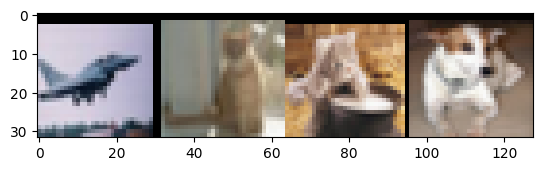

Class labels:  plane cat   cat   dog  


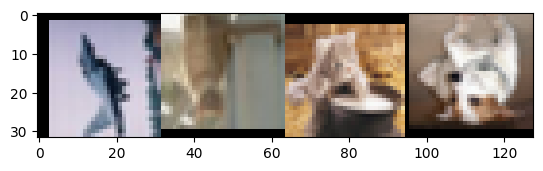

Rotation labels:  90    180   0     180  


In [4]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

#Evaluation code

In [5]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            predicted = torch.max(outputs.data,1)[1]

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [6]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

#Train a ResNet18 on the rotation task

In this section, we will train a ResNet18 model on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(num_classes=4)
net = net.to(device)

In [9]:
import torch.optim as optim
criterion = None
optimizer = None

# TODO: Define criterion and optimizer
optimizer = optim.Adam(params = net.parameters() ,lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

In [10]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)

            # TODO: Set the data to the correct device; Different task will use different inputs and labels
            if task == "rotation":
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == "classification":
              images, labels = imgs.to(device), cls_label.to(device)

            # TODO: Zero the parameter gradients
            optimizer.zero_grad()

            # TODO: forward + backward + optimize
            output = net(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results
            predicted = torch.max(output.data,1)[1]

            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()

        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.
        net.eval()
        run_test(net, testloader, criterion, task)

    print('Finished Training')

In [12]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')

# TODO: Save the model
torch.save(net.state_dict(),"./final_project_1.pth")

[1,   100] loss: 1.562 acc: 34.26 time: 5.88
[1,   200] loss: 1.245 acc: 44.40 time: 4.45
[1,   300] loss: 1.250 acc: 45.41 time: 4.20
TESTING:
Accuracy of the network on the 10000 test images: 51.67 %
Average loss on the 10000 test images: 1.103
[2,   100] loss: 1.140 acc: 50.24 time: 4.34
[2,   200] loss: 1.101 acc: 51.51 time: 4.27
[2,   300] loss: 1.103 acc: 52.13 time: 4.34
TESTING:
Accuracy of the network on the 10000 test images: 55.01 %
Average loss on the 10000 test images: 1.053
[3,   100] loss: 1.072 acc: 54.02 time: 4.44
[3,   200] loss: 1.061 acc: 54.62 time: 4.51
[3,   300] loss: 1.045 acc: 55.31 time: 4.06
TESTING:
Accuracy of the network on the 10000 test images: 57.87 %
Average loss on the 10000 test images: 0.997
[4,   100] loss: 1.021 acc: 56.99 time: 4.29
[4,   200] loss: 1.021 acc: 56.70 time: 4.37
[4,   300] loss: 0.990 acc: 58.02 time: 4.31
TESTING:
Accuracy of the network on the 10000 test images: 59.25 %
Average loss on the 10000 test images: 0.971
[5,   100] l

##Fine-tuning on the pre-trained model

In this section, we will load the pre-trained ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'


In [11]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
pretrained_dict = torch.load('./final_project_1.pth') # Load your pretrained weights

In [12]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
net = resnet18(pretrained=False)
net.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10

# Freeze the previous layers
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

# Load the pretrained model
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict() and net.state_dict()[k].shape == pretrained_dict[k].shape}

# Update the current model
net.load_state_dict(pretrained_dict, strict=False)
net = net.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [14]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr = 1e-3)

In [15]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

torch.save(net.state_dict(),"./final_project_2_rotation.pth")

[1,   100] loss: 1.789 acc: 33.89 time: 4.92
[1,   200] loss: 1.503 acc: 45.48 time: 4.39
[1,   300] loss: 1.438 acc: 46.70 time: 4.14
TESTING:
Accuracy of the network on the 10000 test images: 50.13 %
Average loss on the 10000 test images: 1.390
[2,   100] loss: 1.381 acc: 49.78 time: 4.79
[2,   200] loss: 1.372 acc: 50.03 time: 4.71
[2,   300] loss: 1.366 acc: 50.59 time: 4.23
TESTING:
Accuracy of the network on the 10000 test images: 52.38 %
Average loss on the 10000 test images: 1.323
[3,   100] loss: 1.341 acc: 51.37 time: 4.24
[3,   200] loss: 1.311 acc: 52.06 time: 4.45
[3,   300] loss: 1.297 acc: 52.80 time: 4.90
TESTING:
Accuracy of the network on the 10000 test images: 52.65 %
Average loss on the 10000 test images: 1.320
[4,   100] loss: 1.289 acc: 53.66 time: 4.42
[4,   200] loss: 1.296 acc: 53.77 time: 4.41
[4,   300] loss: 1.282 acc: 53.02 time: 4.16
TESTING:
Accuracy of the network on the 10000 test images: 55.99 %
Average loss on the 10000 test images: 1.231
[5,   100] l

## Fine-tuning on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)
net.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10

In [17]:
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable
# To do this, you should set requires_grad=False for the frozen layers.
pretrained_dict = net.state_dict()

for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False

# Load the pretrained model
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict() and net.state_dict()[k].shape == pretrained_dict[k].shape}

# Update the current model
net.load_state_dict(pretrained_dict, strict=False)
net = net.to(device)

In [18]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [19]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(params_to_update, lr = 1e-3, weight_decay = 5e-4)

In [20]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(),"./final_project_2_random.pth")

[1,   100] loss: 2.216 acc: 25.51 time: 4.26
[1,   200] loss: 1.922 acc: 30.37 time: 3.97
[1,   300] loss: 1.889 acc: 31.24 time: 4.08
TESTING:
Accuracy of the network on the 10000 test images: 33.58 %
Average loss on the 10000 test images: 1.819
[2,   100] loss: 1.859 acc: 32.07 time: 4.27
[2,   200] loss: 1.879 acc: 31.28 time: 4.13
[2,   300] loss: 1.858 acc: 32.50 time: 3.85
TESTING:
Accuracy of the network on the 10000 test images: 33.18 %
Average loss on the 10000 test images: 1.824
[3,   100] loss: 1.836 acc: 33.27 time: 4.21
[3,   200] loss: 1.831 acc: 33.80 time: 3.97
[3,   300] loss: 1.843 acc: 32.69 time: 4.13
TESTING:
Accuracy of the network on the 10000 test images: 35.23 %
Average loss on the 10000 test images: 1.772
[4,   100] loss: 1.826 acc: 33.53 time: 4.24
[4,   200] loss: 1.804 acc: 34.73 time: 4.06
[4,   300] loss: 1.826 acc: 34.16 time: 3.84
TESTING:
Accuracy of the network on the 10000 test images: 35.77 %
Average loss on the 10000 test images: 1.748
[5,   100] l

##Supervised training on the pre-trained model
In this section, we will load the pre-trained ResNet18 model and re-train the whole model on the classification task.

In [21]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Load the pre-trained ResNet18 model
pretrained_model = resnet18(pretrained=False) # set to False if you don't want to download pretrained weights on ImageNet
net = resnet18(pretrained=False)
net.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10

pretrained_dict = torch.load('./final_project_1.pth') # Load your pretrained weights
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net.state_dict() and net.state_dict()[k].shape == pretrained_dict[k].shape}

net.load_state_dict(pretrained_dict, strict=False)
net = net.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [22]:
# TODO: Define criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

In [23]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(),"./final_project_3_rotation.pth")

[1,   100] loss: 1.510 acc: 43.82 time: 4.31
[1,   200] loss: 1.184 acc: 57.44 time: 4.07
[1,   300] loss: 1.082 acc: 61.56 time: 3.92
TESTING:
Accuracy of the network on the 10000 test images: 65.75 %
Average loss on the 10000 test images: 0.982
[2,   100] loss: 0.979 acc: 65.96 time: 4.49
[2,   200] loss: 0.926 acc: 67.66 time: 3.91
[2,   300] loss: 0.907 acc: 68.29 time: 4.04
TESTING:
Accuracy of the network on the 10000 test images: 71.34 %
Average loss on the 10000 test images: 0.826
[3,   100] loss: 0.834 acc: 70.80 time: 4.26
[3,   200] loss: 0.837 acc: 70.63 time: 4.08
[3,   300] loss: 0.814 acc: 71.86 time: 3.90
TESTING:
Accuracy of the network on the 10000 test images: 72.81 %
Average loss on the 10000 test images: 0.792
[4,   100] loss: 0.755 acc: 73.83 time: 4.66
[4,   200] loss: 0.770 acc: 73.02 time: 3.99
[4,   300] loss: 0.745 acc: 74.31 time: 3.81
TESTING:
Accuracy of the network on the 10000 test images: 73.74 %
Average loss on the 10000 test images: 0.768
[5,   100] l

##Supervised training on the randomly initialized model
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [24]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

# TODO: Randomly initialize a ResNet18 model
net = resnet18(pretrained=False)
net.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10
net = net.to(device)

In [25]:
# TODO: Define criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-3)

In [26]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')
torch.save(net.state_dict(),"./final_project_3_random.pth")

[1,   100] loss: 2.274 acc: 21.02 time: 4.14
[1,   200] loss: 1.897 acc: 30.38 time: 4.12
[1,   300] loss: 1.751 acc: 35.24 time: 3.91
TESTING:
Accuracy of the network on the 10000 test images: 42.31 %
Average loss on the 10000 test images: 1.616
[2,   100] loss: 1.558 acc: 41.73 time: 4.45
[2,   200] loss: 1.482 acc: 45.27 time: 4.17
[2,   300] loss: 1.412 acc: 47.53 time: 4.00
TESTING:
Accuracy of the network on the 10000 test images: 52.43 %
Average loss on the 10000 test images: 1.304
[3,   100] loss: 1.270 acc: 53.91 time: 4.34
[3,   200] loss: 1.246 acc: 54.86 time: 4.28
[3,   300] loss: 1.177 acc: 57.98 time: 4.00
TESTING:
Accuracy of the network on the 10000 test images: 61.15 %
Average loss on the 10000 test images: 1.101
[4,   100] loss: 1.088 acc: 61.08 time: 4.12
[4,   200] loss: 1.099 acc: 61.17 time: 4.07
[4,   300] loss: 1.031 acc: 63.29 time: 4.12
TESTING:
Accuracy of the network on the 10000 test images: 66.30 %
Average loss on the 10000 test images: 0.959
[5,   100] l

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


TESTING:
Accuracy of the network on the 10000 test images: 21.61 %
Average loss on the 10000 test images: 2.286
TESTING:
Accuracy of the network on the 10000 test images: 34.62 %
Average loss on the 10000 test images: 1.972
TESTING:
Accuracy of the network on the 10000 test images: 38.44 %
Average loss on the 10000 test images: 1.644
TESTING:
Accuracy of the network on the 10000 test images: 48.74 %
Average loss on the 10000 test images: 1.461
TESTING:
Accuracy of the network on the 10000 test images: 60.05 %
Average loss on the 10000 test images: 1.176
TESTING:
Accuracy of the network on the 10000 test images: 53.38 %
Average loss on the 10000 test images: 1.294
TESTING:
Accuracy of the network on the 10000 test images: 69.02 %
Average loss on the 10000 test images: 0.908
TESTING:
Accuracy of the network on the 10000 test images: 56.62 %
Average loss on the 10000 test images: 1.225
TESTING:
Accuracy of the network on the 10000 test images: 80.36 %
Average loss on the 10000 test images

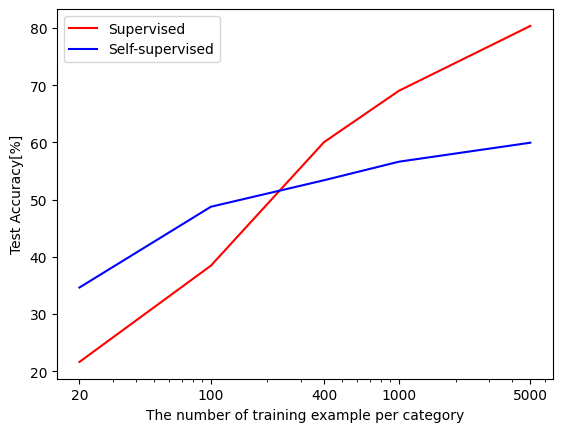

In [28]:
from torch.utils.data import DataLoader, Dataset, Subset

def get_indices_per_category(dataset, num_examples_per_category):
    """Get indices for the specified number of examples per category."""
    class_indices = {i: [] for i in range(10)}  # CIFAR-10 has 10 classes

    for idx, (_, _, _ , label) in enumerate(dataset, 0):
        class_indices[label.item()].append(idx)

    sampled_indices = []
    for class_id, indices in class_indices.items():
        if num_examples_per_category > len(indices):
            raise ValueError(f"Not enough examples in class {class_id} to sample {num_examples_per_category} examples.")
        sampled_indices.extend(random.sample(indices, num_examples_per_category))

    return sampled_indices

def create_dataloaders(dataset, examples_per_category_list, batch_size=32):
    dataloaders = {}

    for num_examples in examples_per_category_list:
        indices = get_indices_per_category(dataset, num_examples)
        subset = Subset(dataset, indices)
        dataloaders[num_examples] = DataLoader(subset, batch_size=batch_size, shuffle=True)

    return dataloaders

def test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            # TODO: Calculate outputs by running images through the network
            # The class with the highest energy is what we choose as prediction
            outputs = net(images)
            predicted = torch.max(outputs.data,1)[1]

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # loss
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')
    return avg_test_loss.item(), 100*correct/total

N_lst = [20,100,400,1000,5000]
dataloaders = create_dataloaders(trainset, N_lst)

logger = {'supervised' : [], 'self-supervised' : []}

for N in N_lst:
  sampled_examples = dataloaders[N]
  model_supervised = resnet18(pretrained=False)
  model_supervised.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10
  model_supervised = model_supervised.to(device)

  pretrained_dict = torch.load('./model') # Load your pretrained weights
  model_self_supervised = resnet18(pretrained=False)
  model_self_supervised.fc = nn.Linear(512, 10) # Change the last layer for CIFAR10

  for name, param in model_self_supervised.named_parameters():
      if 'layer4' not in name and 'fc' not in name:
          param.requires_grad = False

  pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_self_supervised.state_dict() and model_self_supervised.state_dict()[k].shape == pretrained_dict[k].shape}
  model_self_supervised.load_state_dict(pretrained_dict, strict=False)
  model_self_supervised = model_self_supervised.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer1 = optim.Adam(params = model_supervised.parameters(), lr = 0.01)
  optimizer2 = optim.Adam(params = model_self_supervised.parameters(), lr = 0.01)

  scheduler1 = optim.lr_scheduler.LambdaLR(optimizer=optimizer1,
                                          lr_lambda=lambda epoch: 0.95 ** epoch,
                                          last_epoch=-1,
                                          verbose=False)

  scheduler2 = optim.lr_scheduler.LambdaLR(optimizer=optimizer2,
                                          lr_lambda=lambda epoch: 0.95 ** epoch,
                                          last_epoch=-1,
                                          verbose=False)

  for epochs in range(30):
    for imgs,_ ,_ , labels in sampled_examples:
      imgs, labels = imgs.to(device), labels.to(device)

      assert imgs.is_cuda and labels.is_cuda, "Tensors should be on GPU"

      optimizer1.zero_grad()
      output_supervised = model_supervised(imgs)
      loss_supervised = criterion(output_supervised, labels)
      loss_supervised.backward()
      optimizer1.step()

      optimizer2.zero_grad()
      output_self_supervised = model_self_supervised(imgs)
      loss_self_supervised = criterion(output_self_supervised, labels)
      loss_self_supervised.backward()
      optimizer2.step()

  scheduler1.step()
  scheduler2.step()

  _, supervised_acc = test(model_supervised, testloader, criterion, "classification")
  _, self_supervised_acc = test(model_self_supervised, testloader, criterion, "classification")

  logger['supervised'].append(supervised_acc)
  logger['self-supervised'].append(self_supervised_acc)

plt.semilogx(N_lst, logger['supervised'],color = 'r',label = "Supervised")
plt.semilogx(N_lst, logger['self-supervised'],color = 'b',label = "Self-supervised")
plt.xticks([20, 100, 400, 1000, 5000],labels = ['20', '100', '400', '1000', '5000'])
plt.ylabel("Test Accuracy[%]")
plt.xlabel("The number of training example per category")
plt.legend()`
